# Installing Packages

In [1]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install yellowbrick
!{sys.executable} -m pip install matplot
!{sys.executable} -m pip install seaborn

# Preprocessing of Data

In [2]:
import os
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer

import copy

# Helper function: simply reads a csv file and return it as a dataframe
def read_data(data_file):
  data_df = pd.read_csv(data_file)
  return data_df

def drop_features(data_df, features_to_drop):
  return data_df.drop(columns=features_to_drop, inplace=True)

def segregate_noisy_data(data_df):
  copied_data = copy.deepcopy(data_df)
  non_noisy_df = copied_data.loc[(copied_data['noisy_train'] == 0)]
  noisy_df = copied_data.loc[(copied_data['noisy_train'] == 1)]
  return non_noisy_df, noisy_df

def remove_noisy_data(data_df):
  print(f'''Rows dropped because of low duration: 
        {len(data_df[data_df['noisy'] == 1])}\n''')
  
  return data_df.drop(data_df[data_df['noisy'] == 1].index, inplace=True)

# Helper function: cleans data based on xyz
def preprocessing_data(data_df):

  # Clean data based on duration value
  print(f'''Rows dropped because of low duration: \
        {len(data_df[data_df['duration'] < 2])}\n''')
  
  data_df.drop(data_df[data_df['duration'] < 2].index, inplace=True)

  # Extract filenames
  filenames = data_df['file_name'].values.tolist()

  return (data_df, filenames)


Read Data

In [3]:
# Fetch .csv file and store it as a dataframe
aggression_data_df = read_data('../extracted/full-train-features.csv')

Extract data, filenames and labels after preprocessing data

In [4]:
print(f'Shape of the data before cleaning it: {aggression_data_df.shape}\n')
print(aggression_data_df.tail())

aggression_data_df, filenames = preprocessing_data(aggression_data_df)

print(f'Shape of the data after cleaning it: {aggression_data_df.shape} \n')

Shape of the data before cleaning it: (2147, 23)

                      file_name  duration  analyse_harmonics  \
2142  xdz15thrnem51_processed_5      10.0           5.465491   
2143  xdz15thrnem51_processed_6      10.0           6.879443   
2144  xdz15thrnem51_processed_7      10.0           4.468770   
2145  xdz15thrnem51_processed_8      10.0           8.581945   
2146  xdz15thrnem51_processed_9      10.0           2.829222   

      get_number_sylls  get_number_words  pauses get_max_intensity  \
2142               1.3               1.0     0.1       104.1138965   
2143               0.2               0.3     0.1        108.028173   
2144               1.8               1.1     0.1       104.6782678   
2145               0.3               0.1     0.1        109.335715   
2146               0.6               0.6     0.1       105.4555978   

      analyse_intensity  analyse_pitch  analyse_pitch_range  ...  \
2142          69.550541     199.893943           443.057705  ...   
2143    

Segregate data based on noisy vs not noisy

In [5]:
non_noisy_df, noisy_df = segregate_noisy_data(aggression_data_df)

print(f"Shape of noisy data: {noisy_df.shape} \n")
print(f"Shape of non noisy data: {non_noisy_df.shape}\n")

Shape of noisy data: (262, 23) 

Shape of non noisy data: (1849, 23)



**NOTE: Modelling of this project is split into 3 groups. Therefore, all the steps in this notebook below are repeated once for each group**
1. Noisy and Non Noisy Data
2. Noisy Data
3. Non Noisy Data

Drop features

In [6]:
features_to_drop = ['file_name', 'duration','get_number_sylls',
                    'get_number_words', 'pauses',
                    'number_of_segments_train', 'number_of_voices_parent_train',
                    'extra_sounds_train', 'Notes_train']

# remove features for Group 1
print(f'Shape of the data for Group 1 before dropping features: {aggression_data_df.shape} \n')
drop_features(aggression_data_df, features_to_drop)

# remove features for Group 2
print(f'Shape of the data for Group 2 before dropping features: {non_noisy_df.shape} \n')
drop_features(non_noisy_df, features_to_drop)

# remove features for Group 3
print(f'Shape of the data for Group 3 before dropping features: {noisy_df.shape} \n')
drop_features(noisy_df, features_to_drop)


print(f'Shape of the data for Group 1 after dropping features: {aggression_data_df.shape} \n')
print(f'Shape of the data for Group 2 after dropping features: {non_noisy_df.shape} \n')
print(f'Shape of the data for Group 3 after dropping features: {noisy_df.shape} \n')

Shape of the data for Group 1 before dropping features: (2111, 23) 

Shape of the data for Group 2 before dropping features: (1849, 23) 

Shape of the data for Group 3 before dropping features: (262, 23) 

Shape of the data for Group 1 after dropping features: (2111, 14) 

Shape of the data for Group 2 after dropping features: (1849, 14) 

Shape of the data for Group 3 after dropping features: (262, 14) 



### Examine dataframe from each group

In [7]:
print(aggression_data_df.info())
print(non_noisy_df.info())
print(noisy_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2111 entries, 0 to 2146
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   analyse_harmonics      2111 non-null   float64
 1   get_max_intensity      2111 non-null   object 
 2   analyse_intensity      2111 non-null   float64
 3   analyse_pitch          2110 non-null   float64
 4   analyse_pitch_range    2110 non-null   float64
 5   analyse_shimmer        2110 non-null   float64
 6   analyse_jitter         2110 non-null   float64
 7   spectral_slope         2111 non-null   float64
 8   mean_spectral_rolloff  2111 non-null   float64
 9   get_energy             2111 non-null   float64
 10  parent_file_train      2111 non-null   object 
 11  parent_label_train     2111 non-null   int64  
 12  segment_label_train    2111 non-null   int64  
 13  noisy_train            2111 non-null   int64  
dtypes: float64(9), int64(3), object(2)
memory usage: 247.4+ 

Remove rows that have `NaN` as one of the feature values

1 row in both group 1 and group 2 have `NaN`

In [8]:
aggression_data_df.dropna(inplace=True)
non_noisy_df.dropna(inplace=True)
noisy_df.dropna(inplace=True)


Convert values in 'get_max_intensity' from string to float 

In [9]:
aggression_data_df['get_max_intensity'] = pd.to_numeric(aggression_data_df['get_max_intensity'])
non_noisy_df['get_max_intensity'] = pd.to_numeric(non_noisy_df['get_max_intensity'])
noisy_df['get_max_intensity'] = pd.to_numeric(noisy_df['get_max_intensity'])

noisy_df.head(15)

,analyse_harmonics,get_max_intensity,analyse_intensity,analyse_pitch,analyse_pitch_range,analyse_shimmer,analyse_jitter,spectral_slope,mean_spectral_rolloff,get_energy,parent_file_train,parent_label_train,segment_label_train,noisy_train
0,2.071884,108.591944,76.429126,355.354649,517.899150,0.193371,0.039075,-0.091534,1711.357507,0.174962,00g8dfgpqpt61,0,0,1
1,1.548685,107.108480,78.207339,409.030438,491.537960,0.202199,0.049623,-0.090760,1469.373610,0.263521,00g8dfgpqpt62,0,0,1
2,2.202973,110.003934,77.650102,393.605328,511.080779,0.200674,0.038352,-0.116676,1287.538989,0.231453,00g8dfgpqpt63,0,0,1
3,4.541632,100.037201,67.432142,358.021668,448.489253,0.201583,0.035544,-0.010975,1251.558111,0.022047,01avx2fm1t961,3,3,1
4,3.790801,98.041081,63.570349,373.512829,519.744413,0.190743,0.046422,-0.004044,1387.495977,0.009121,01avx2fm1t961,3,2,1
5,3.859515,99.656235,66.680578,394.698825,461.355272,0.181399,0.038183,-0.011376,1164.256959,0.018612,01avx2fm1t961,3,2,1
6,4.301706,100.620469,67.893825,355.316875,439.101386,0.199342,0.043200,-0.014285,1043.864847,0.025372,01avx2fm1t961,3,2,1
7,4.134565,101.666306,68.782272,381.025067,513.486703,0.192137,0.038323,-0.017456,1025.571987,0.028210,01avx2fm1t961,3,2,1
64,4.832865,108.258940,77.036272,219.231909,499.293824,0.173476,0.024539,-0.089942,1778.052375,0.139028,09etqbnf0uc61,0,0,1
88,3.707670,107.282961,77.338457,107.077688,523.583154,0.161535,0.027049,-0.157909,903.503189,0.216111,0cho11mt05y51,0,0,1


Segregate data df and label df and reset indexes from all groups

In [10]:
feature_labels = ['parent_label_train', 'segment_label_train', 'noisy_train']

label_df = aggression_data_df.filter(items=feature_labels)
aggression_df = aggression_data_df#.drop(columns=feature_labels)

label_non_noisy_df = non_noisy_df.filter(items=feature_labels)
aggression_non_noisy_df = non_noisy_df#.drop(columns=feature_labels)

label_noisy_df = noisy_df.filter(items=feature_labels)
aggression_noisy_df = noisy_df#.drop(columns=feature_labels)

label_df.reset_index(drop=True, inplace=True)
aggression_df.reset_index(drop=True, inplace=True)

label_non_noisy_df.reset_index(drop=True, inplace=True)
aggression_non_noisy_df.reset_index(drop=True, inplace=True)

label_noisy_df.reset_index(drop=True, inplace=True)
aggression_noisy_df.reset_index(drop=True, inplace=True)

print(f"Shape of labelled data in Group 1:{label_df.shape} \n Shape of data in Group 1: {aggression_df.shape}\n")
print(f"Shape of labelled data in Group 2:{label_non_noisy_df.shape} \n Shape of data in Group 2: {aggression_non_noisy_df.shape}\n")
print(f"Shape of labelled data in Group 3:{label_noisy_df.shape} \n Shape of data in Group 3: {aggression_noisy_df.shape}\n")

Shape of labelled data in Group 1:(2110, 3) 
 Shape of data in Group 1: (2110, 14)

Shape of labelled data in Group 2:(1848, 3) 
 Shape of data in Group 2: (1848, 14)

Shape of labelled data in Group 3:(262, 3) 
 Shape of data in Group 3: (262, 14)



ROUGH CODE BLOCK BELOW: Extra code to run model against parent labels and not segment labels

In [11]:
aggression_df #label_df

,analyse_harmonics,get_max_intensity,analyse_intensity,analyse_pitch,analyse_pitch_range,analyse_shimmer,analyse_jitter,spectral_slope,mean_spectral_rolloff,get_energy,parent_file_train,parent_label_train,segment_label_train,noisy_train
0,2.071884,108.591944,76.429126,355.354649,517.899150,0.193371,0.039075,-0.091534,1711.357507,0.174962,00g8dfgpqpt61,0,0,1
1,1.548685,107.108480,78.207339,409.030438,491.537960,0.202199,0.049623,-0.090760,1469.373610,0.263521,00g8dfgpqpt62,0,0,1
2,2.202973,110.003934,77.650102,393.605328,511.080779,0.200674,0.038352,-0.116676,1287.538989,0.231453,00g8dfgpqpt63,0,0,1
3,4.541632,100.037201,67.432142,358.021668,448.489253,0.201583,0.035544,-0.010975,1251.558111,0.022047,01avx2fm1t961,3,3,1
4,3.790801,98.041081,63.570349,373.512829,519.744413,0.190743,0.046422,-0.004044,1387.495977,0.009121,01avx2fm1t961,3,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2105,5.465491,104.113896,69.550541,199.893943,443.057705,0.196757,0.033226,-0.020890,1002.676098,0.036482,xdz15thrnem51,2,1,0
2106,6.879443,108.028173,75.501002,258.536830,379.915372,0.149580,0.024206,-0.081411,1023.670363,0.141290,xdz15thrnem51,2,2,0
2107,4.468770,104.678268,71.100226,194.904220,493.340814,0.162628,0.034465,-0.028155,980.207236,0.051732,xdz15thrnem51,2,1,0
2108,8.581945,109.335715,76.784989,285.988051,520.259229,0.149758,0.022509,-0.108299,1146.211888,0.190454,xdz15thrnem51,2,2,0


In [12]:
# print(aggression_noisy_df.tail(10))

to_add = aggression_noisy_df.parent_file_train.unique()

actual_noisy_test_df = pd.DataFrame(to_add, columns = ['filename'])
actual_noisy_test_df["parent_label"] = -1

actual_noisy_test_df.head()

for fn in to_add:    
    actual_noisy_test_df.loc[actual_noisy_test_df['filename'] == fn, ['parent_label']] = noisy_df.loc[noisy_df.parent_file_train == fn, 'parent_label_train'].values[0]
    # actual_noisy_test_df.at[0, fn] = aggression_noisy_df.iloc[0][fn]

actual_noisy_test_df
# print(noisy_df.loc[noisy_df.parent_file_train == '3nvn1lwacgg61', 'parent_label_train'].values[0])

,filename,parent_label
0,00g8dfgpqpt61,0
1,00g8dfgpqpt62,0
2,00g8dfgpqpt63,0
3,01avx2fm1t961,3
4,09etqbnf0uc61,0
...,...,...
69,wjha1sf516b71,0
70,wkgibcp6fro51,0
71,wocoyi48sgs51,2
72,xbw64yf04th51,1


# Standardization

In [13]:
from sklearn.preprocessing import StandardScaler

# Helper function: returns a standardized dataframe
def standardize(df):
    org_features = df.columns
    features = [i for i in df.columns if i not in ['parent_file_train'] + feature_labels]
    
    values_array = df.loc[:, features].values

    # Print data before standardization to compare
    print("Before Standardization \n")
    print("Mean and Standard Deviation")
    print(f"Mean = {np.mean(values_array)} ; Standard Deviation = {np.std(values_array)}")
    print(f"Shape to verify: {values_array.shape} \n")
    print(f"Tail of the data pre standardization: \n{values_array[-5:]} \n\n")

    # Invoke standardization
    # Numeric columns: Std scaler
    pipeline = ColumnTransformer([
        ('transform_numeric',StandardScaler(),features),    
    ], remainder='passthrough')


    # Transform input vector (features)
    df =  pd.DataFrame(pipeline.fit_transform(df),columns=org_features)
    
    #values_array = StandardScaler().fit_transform(values_array)
    
    values_array = df.loc[:, features].values  # To do the below computation
    # Print data after standardization to compare
    print("After Standardization \n")
    print("Mean and Standard Deviation")
    print(f"Mean = {np.mean(values_array)} ; Standard Deviation = {np.std(values_array)}")
    print(f"Shape to verify: {values_array.shape}")
    print(f"Tail of the data post standardization: \n{values_array[-5:]}")

    return df

Standardize data for all groups

In [14]:
standardized_aggression_df = standardize(aggression_df)
standardized_non_noisy_df = standardize(aggression_non_noisy_df)
standardized_noisy_df = standardize(aggression_noisy_df)

Before Standardization 

Mean and Standard Deviation
Mean = 207.03214462485482 ; Standard Deviation = 405.89809500083527
Shape to verify: (2110, 10) 

Tail of the data pre standardization: 
[[ 5.46549109e+00  1.04113896e+02  6.95505405e+01  1.99893943e+02
   4.43057705e+02  1.96756913e-01  3.32257430e-02 -2.08904800e-02
   1.00267610e+03  3.64816420e-02]
 [ 6.87944281e+00  1.08028173e+02  7.55010015e+01  2.58536830e+02
   3.79915372e+02  1.49580347e-01  2.42058080e-02 -8.14106130e-02
   1.02367036e+03  1.41290270e-01]
 [ 4.46876994e+00  1.04678268e+02  7.11002256e+01  1.94904220e+02
   4.93340814e+02  1.62627554e-01  3.44649850e-02 -2.81549870e-02
   9.80207236e+02  5.17316800e-02]
 [ 8.58194493e+00  1.09335715e+02  7.67849889e+01  2.85988051e+02
   5.20259229e+02  1.49757852e-01  2.25093080e-02 -1.08298994e-01
   1.14621189e+03  1.90454480e-01]
 [ 2.82922212e+00  1.05455598e+02  7.46545323e+01  1.86190085e+02
   4.86287854e+02  1.95173250e-01  3.43624990e-02 -8.18768770e-02
   6.98359

In [15]:
standardized_aggression_df

,analyse_harmonics,get_max_intensity,analyse_intensity,analyse_pitch,analyse_pitch_range,analyse_shimmer,analyse_jitter,spectral_slope,mean_spectral_rolloff,get_energy,parent_file_train,parent_label_train,segment_label_train,noisy_train
0,-1.229415,0.816248,0.877741,1.42237,0.857657,0.898334,0.355641,-0.331514,0.907009,0.498579,00g8dfgpqpt61,0,0,1
1,-1.369057,0.541133,1.180279,2.008275,0.626936,1.131041,1.008834,-0.322634,0.438397,1.124945,00g8dfgpqpt62,0,0,1
2,-1.194428,1.078107,1.085473,1.8399,0.79798,1.090856,0.310873,-0.620007,0.086267,0.898132,00g8dfgpqpt63,0,0,1
3,-0.570238,-0.770265,-0.652971,1.451482,0.250161,1.114803,0.136983,0.592854,0.016588,-0.582963,01avx2fm1t961,3,3,1
4,-0.770635,-1.140454,-1.310001,1.620578,0.873807,0.829075,0.810602,0.672384,0.279838,-0.674388,01avx2fm1t961,3,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2105,-0.323659,-0.014225,-0.292555,-0.274583,0.202622,0.987592,-0.006539,0.479082,-0.465383,-0.480872,xdz15thrnem51,2,1,0
2106,0.053725,0.711694,0.719834,0.365542,-0.350018,-0.25594,-0.565074,-0.215352,-0.424726,0.260425,xdz15thrnem51,2,2,0
2107,-0.589685,0.09044,-0.028897,-0.329049,0.642715,0.087973,0.070198,0.395726,-0.508895,-0.37301,xdz15thrnem51,2,1,0
2108,0.508124,0.954183,0.938286,0.665189,0.878313,-0.251261,-0.670125,-0.523881,-0.187419,0.608156,xdz15thrnem51,2,2,0


# Modelling

In [16]:
%matplotlib inline
import copy
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn import svm, mixture
from sklearn.model_selection import GridSearchCV, train_test_split

def hyperparameter_tuning(ml_model, data, label, parameters):
    clf = GridSearchCV(ml_model, parameters, refit=True, verbose=0, scoring='f1_weighted', n_jobs=-1)
    clf.fit(data, label)
    print(clf.best_params_)

def run_model(ml_model, data, label, label_name):
    model = copy.deepcopy(ml_model)
    
    # Only train on this feature set
    feature_set = data.drop(['parent_file_train']+feature_labels,axis=1).columns  # Only these features will be fed to the model
    print('Feature set:',feature_set)
    
    actual_labels = np.empty([0], dtype=int)
    predicted_labels = np.empty([0], dtype=int)

    X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.25)
    
    
    model.fit(X_train[feature_set], y_train)
    y_pred = model.predict(X_test[feature_set])
    
    X_test['segment_predictions'] = y_pred  # To store prediction with rest of the data
    #X_test['segment_actual'] = y_test  # To store prediction with rest of the data

    actual_labels = np.append(actual_labels, y_test)
    predicted_labels = np.append(predicted_labels, y_pred)

    acc_score = accuracy_score(y_test, y_pred)
    prec_score = precision_score(y_test, y_pred, average='weighted')
    rec_score = recall_score(y_test, y_pred, average='weighted')
    fone_score = f1_score(y_test, y_pred, average='weighted')

    print(f'F1 score = {fone_score}; Accuracy score = {acc_score} ; Precisison Score = {prec_score}; Recall score = {rec_score}')

    return actual_labels, predicted_labels, X_test

def confusion_matrix_graph(model_name, actual_labels, predicted_labels, label_names):
    matrix = confusion_matrix(actual_labels, predicted_labels)

    plt.figure(figsize=(14, 8))
    ax = sns.heatmap(matrix, annot=True, xticklabels=label_names, yticklabels=label_names, cmap="Greens")
    ax.set_title(model_name);
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual');

    print("\n\n Aggregate report \n", classification_report(actual_labels, predicted_labels, target_names=label_names))

    plt.show()    



Convert dataframes to numpy array

In [17]:
data_np = standardized_aggression_df.to_numpy()
label_np = label_df['segment_label_train'].to_numpy()

data_non_noisy_np = standardized_non_noisy_df.to_numpy()
label_non_noisy_np = label_non_noisy_df['segment_label_train'].to_numpy()

data_noisy_np = standardized_noisy_df.to_numpy()
label_noisy_np = label_noisy_df['segment_label_train'].to_numpy()

## SVM

Hyperparameter Tuning for SVM

In [18]:
# original_parameters = {'C': [0.01, 0.1, 1, 10, 100, 1000, 10000], 'gamma': ['scale', 'auto'],
#                    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'], 'degree': [1,2,3,4,5,6]}

quick_parameters = {'C': [ 0.1, 1, 10, 100], 'gamma': ['auto'],
                 'kernel': ['rbf', 'linear', 'poly', 'sigmoid'], 'degree': [1]}

svc = svm.SVC()
# hyperparameter_tuning(svc, data_np, label_np, quick_parameters)

Results from hyper parameter tuning for SVM using `original_parameters`: **`{'C': 1, 'degree': 1, 'gamma': 'auto', 'kernel': 'rbf'}`**

***NOTE: `orginal_parameters` were the actual parameters against which the parameters were tuned. However, the results took over 4 hours to be processed. Therefore, `quick_parameters` is just a smaller subset of the `original_parameters`.***

Run SVM model

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.5392461818445357; Accuracy score = 0.553030303030303 ; Precisison Score = 0.5391237161431347; Recall score = 0.553030303030303


 Aggregate report 
               precision    recall  f1-score   support

           0       0.65      0.75      0.70       236
           1       0.46      0.50      0.48       143
           2       0.34      0.24      0.28        91
           3       0.59      0.34      0.43        58

    accuracy                           0.55       528
   macro avg       0.51      0.46      0.47       528
weighted avg       0.54      0.55      0.54       528



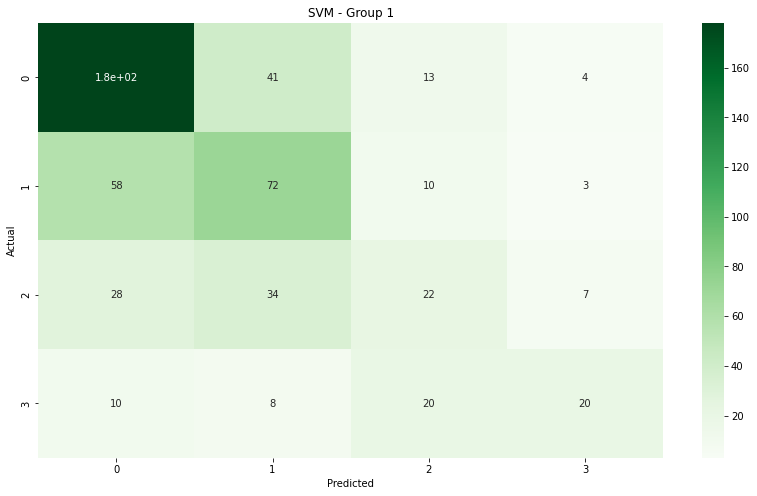

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.5261328220223412; Accuracy score = 0.5454545454545454 ; Precisison Score = 0.5463975751188539; Recall score = 0.5454545454545454


 Aggregate report 
               precision    recall  f1-score   support

           0       0.65      0.74      0.69       203
           1       0.45      0.57      0.50       134
           2       0.31      0.19      0.23        80
           3       0.79      0.24      0.37        45

    accuracy                           0.55       462
   macro avg       0.55      0.43      0.45       462
weighted avg       0.55      0.55      0.53       462



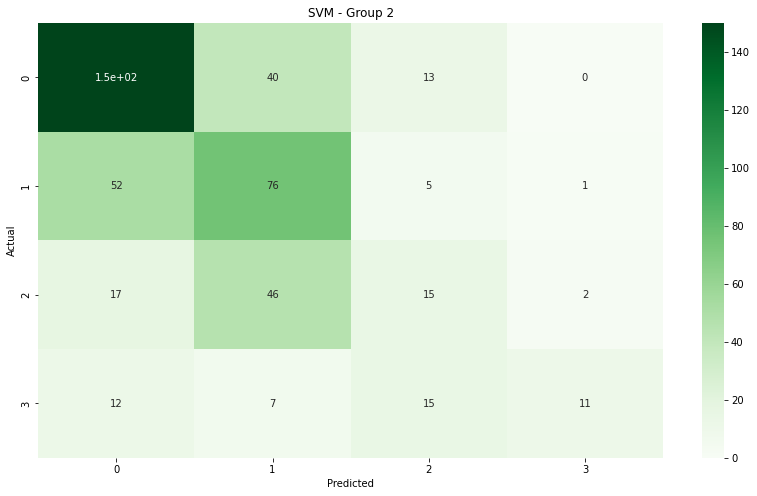

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.6564012639962007; Accuracy score = 0.696969696969697 ; Precisison Score = 0.634032634032634; Recall score = 0.696969696969697


/Users/apple/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/apple/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/apple/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/apple/opt/anaconda3/lib/p



 Aggregate report 
               precision    recall  f1-score   support

           0       0.85      0.82      0.84        40
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         6
           3       0.50      0.81      0.62        16

    accuracy                           0.70        66
   macro avg       0.34      0.41      0.36        66
weighted avg       0.63      0.70      0.66        66



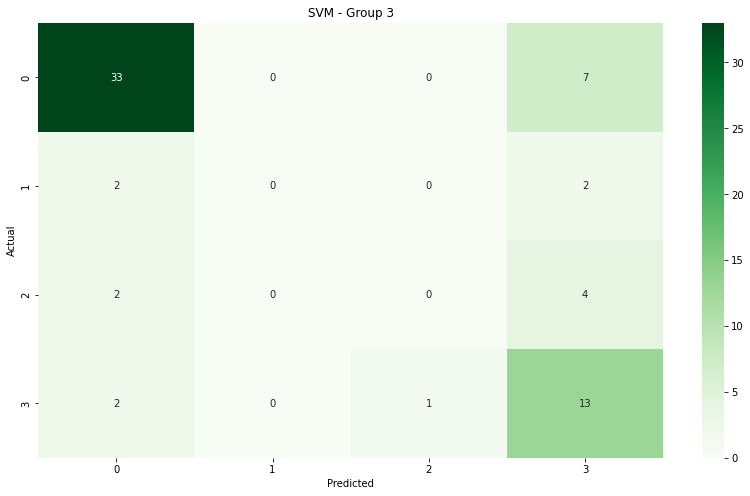

In [21]:
#lst_data_np = [data_np, data_non_noisy_np, data_noisy_np]
lst_label_np = [label_np, label_non_noisy_np, label_noisy_np]
label = 'segment_label_train'
lst_df = [standardized_aggression_df, standardized_non_noisy_df, standardized_noisy_df]
X_test_list = [None,None,None]

for i in range(3):
    svm_model = svm.SVC(kernel='rbf', gamma='auto', C=1, degree=3)
    actual, predicted, X_test_list[i] = run_model(svm_model, lst_df[i], lst_label_np[i],label_name=label)

    confusion_matrix_graph(f"SVM - Group {i+1}", actual, predicted, ['0', '1', '2', '3'])

#### Parent label analysis



 Aggregate report 
               precision    recall  f1-score   support

           0       0.52      0.69      0.59        65
           1       0.34      0.38      0.36        50
           2       0.27      0.26      0.26        47
           3       0.62      0.28      0.39        46

    accuracy                           0.43       208
   macro avg       0.44      0.40      0.40       208
weighted avg       0.44      0.43      0.42       208



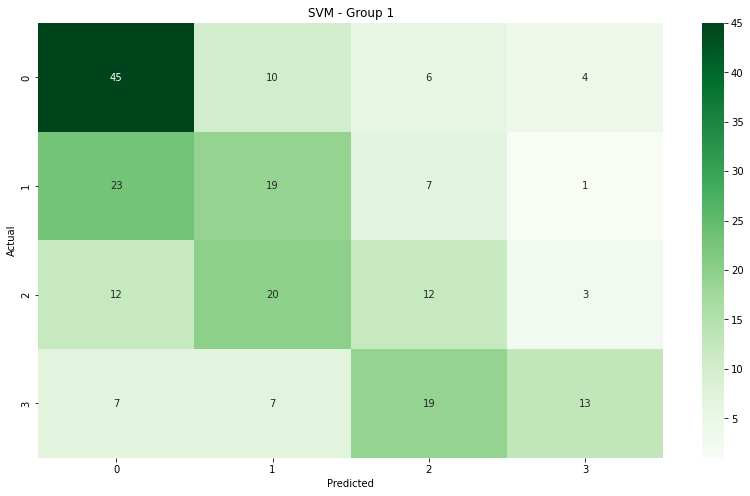



 Aggregate report 
               precision    recall  f1-score   support

           0       0.54      0.70      0.61        57
           1       0.34      0.51      0.41        45
           2       0.35      0.24      0.29        37
           3       1.00      0.18      0.30        34

    accuracy                           0.45       173
   macro avg       0.56      0.41      0.40       173
weighted avg       0.54      0.45      0.43       173



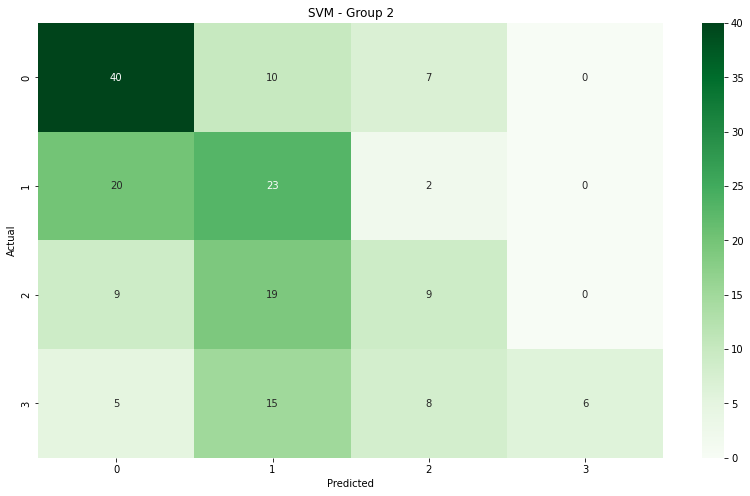



 Aggregate report 
               precision    recall  f1-score   support

           0       0.64      0.76      0.70        21
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00         3
           3       0.44      0.64      0.52        11

    accuracy                           0.55        42
   macro avg       0.27      0.35      0.30        42
weighted avg       0.43      0.55      0.48        42



/Users/apple/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/apple/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/apple/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


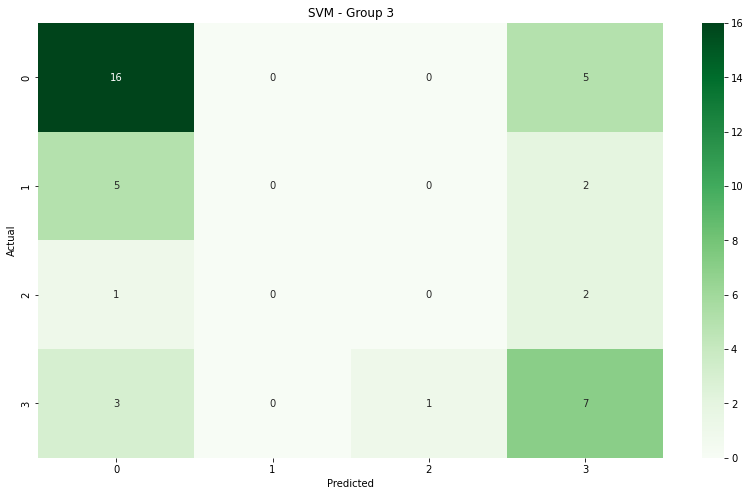

,parent_file_train,parent_label_train,segment_predictions
0,00g8dfgpqpt63,0,3
1,01avx2fm1t961,3,2
2,0202on89vhz61,0,2
3,03mglec8fez51,1,1
4,0653ipqy7vd71,2,0
...,...,...,...
203,x705shsub7m61,1,0
204,xbw64yf04th51,1,0
205,xda96lajcd871,0,0
206,xdz15thrnem51,2,1


In [22]:
max_parent_df_list = []

for i in range(0,len(X_test_list)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list[i]
    #display(df_i)
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    #df_i = lst_df[i] 
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list.append(df_i_merged)
    
    confusion_matrix_graph(f"SVM - Group {i+1}", df_i_merged['parent_label_train'], df_i_merged['segment_predictions'], ['0', '1', '2', '3'])

max_parent_df_list[0]    

#### Previous results

F1 score = 0.5742407229890937; Accuracy score = 0.5871212121212122 ; Precisison Score = 0.5771966214061278; Recall score = 0.5871212121212122


 Aggregate report 
               precision    recall  f1-score   support

           0       0.68      0.79      0.73       244
           1       0.47      0.50      0.49       145
           2       0.38      0.27      0.32        86
           3       0.70      0.40      0.51        53

    accuracy                           0.59       528
   macro avg       0.56      0.49      0.51       528
weighted avg       0.58      0.59      0.57       528



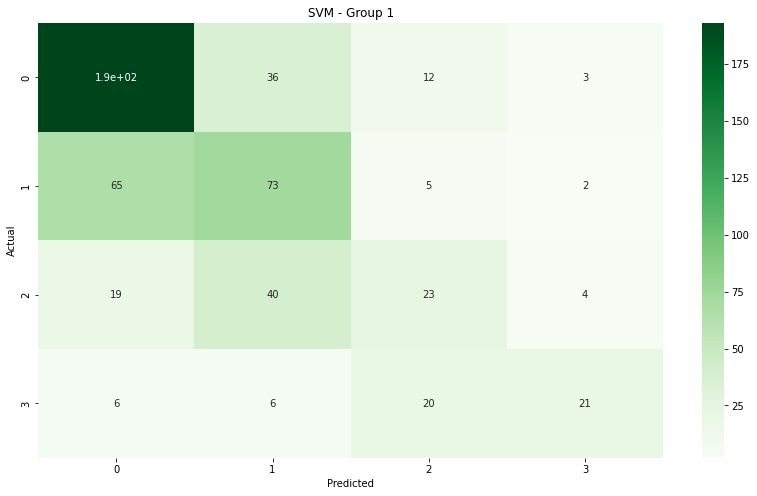

F1 score = 0.5176183049348846; Accuracy score = 0.525974025974026 ; Precisison Score = 0.5201631528140005; Recall score = 0.525974025974026


 Aggregate report 
               precision    recall  f1-score   support

           0       0.60      0.67      0.63       202
           1       0.48      0.50      0.49       160
           2       0.31      0.25      0.28        67
           3       0.62      0.30      0.41        33

    accuracy                           0.53       462
   macro avg       0.51      0.43      0.45       462
weighted avg       0.52      0.53      0.52       462



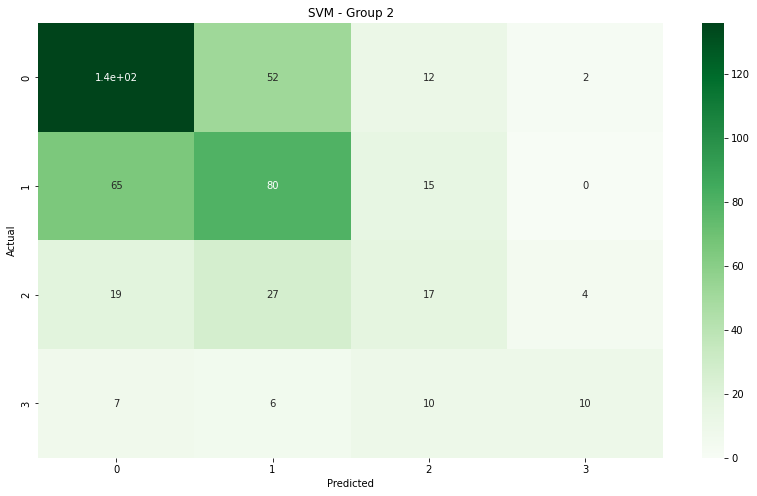

C:\Users\samee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

F1 score = 0.5864290421252446; Accuracy score = 0.6666666666666666 ; Precisison Score = 0.5276021080368906; Recall score = 0.6666666666666666


 Aggregate report 
               precision    recall  f1-score   support

           0       0.65      0.91      0.76        33
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         9
           3       0.70      0.74      0.72        19

    accuracy                           0.67        66
   macro avg       0.34      0.41      0.37        66
weighted avg       0.53      0.67      0.59        66



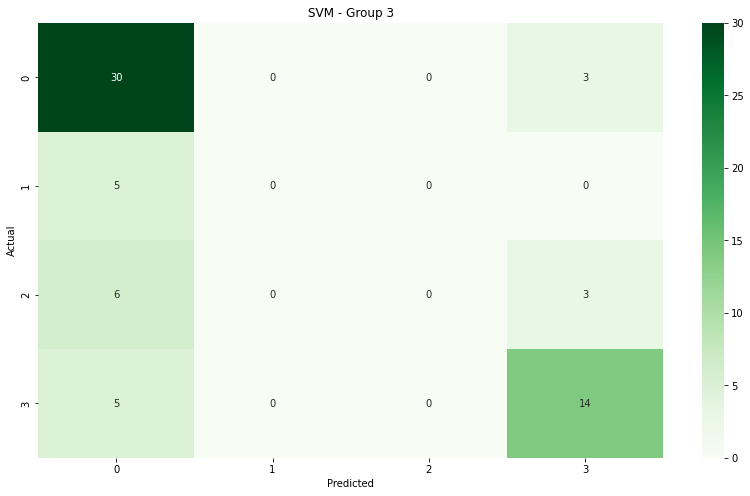

In [ ]:
lst_data_np = [data_np, data_non_noisy_np, data_noisy_np]
lst_label_np = [label_np, label_non_noisy_np, label_noisy_np]


for i in range(3):
    svm_model = svm.SVC(kernel='rbf', gamma='auto', C=1, degree=3)
    actual, predicted = run_model(svm_model, lst_data_np[i], lst_label_np[i])

    confusion_matrix_graph(f"SVM - Group {i+1}", actual, predicted, ['0', '1', '2', '3'])